# [Collision Avoidance Challenge](https://kelvins.esa.int/collision-avoidance-challenge/home/)
## Introduction
Today, active **collision avoidance** among orbiting satellites has become a routine task in space operations, relying on validated, accurate and timely space surveillance data. For a typical satellite in Low Earth Orbit, hundreds of alerts are issued every week corresponding to possible close encounters between a satellite and another space object (in the form of conjunction data messages CDMs). After automatic processing and filtering, there remain about 2 actionable alerts per spacecraft and week, requiring detailed follow-up by an analyst. On average, at the European Space Agency, more than one collision avoidance manoeuvre is performed per satellite and year.


In this challenge, you are tasked to build a model to predict the final collision risk estimate between a given satellite and a space object (e.g. another satellite, space debris, etc). To do so, you will have access to a database of real-world conjunction data messages (CDMs) carefully prepared at ESA. Learn more about the challenge and the data.

This competition is organized by ESA's Advanced Concepts Team (ACT) in partnership with ESA's Space Debris Office

Experts from both teams are available for interactions during the competition.

## Challenge

As of estimations done in January 2019, more than 34,000 objects with a size larger than 10cm are orbiting our planet. Of these, 22,300 are tracked by the Space Surveillance Network and their position released in the form of a globally shared catalogue.


ESA's Space Debris Office supports collision avoidance activities covering the ESA missions Aeolus, Cryosat-2 and the constellation of Swarm-A/B/C in low-Earth orbit and Cluster-II in highly eccentric orbit approaching the Geostationary (GEO) region. On top of these, more than a dozen spacecraft of partner agencies and commercial operators are supported.

![Alt text](https://kelvins.esa.int/media/public/ckeditor_uploads/2021/08/05/new_swarm.png "Title")

In the context of this activity, the orbits of these satellites are propagated and when a close approach with any object in the catalogue is detected a **Conjunction Data Message** (CDM) is assembled and released. Each CDM **contains multiple attributes** about the approach, such as the identity of the satellite in question, the object type of the potential collider, the time of closest approach (TCA), the uncertainty (i.e. covariances), etc. It also contains a **self-reported** risk, which is computed using some of the attributes from the CDM. In the days following the first CDM, as the uncertainties of the objects positions become smaller, other CDMs are released refining the knowledge acquired on the close encounter.

Typically, a **time series** of CDMs covering one week is released **for each unique close approach**, with about 3 CDMs becoming available per day. For a given close approach the last obtained CDM, including the computed risk, can be assumed to be the **best knowledge** we have about the potential collision and the state of the two objects in question. In most cases, the Space Debris Office will alarm control teams and start thinking about a potential avoidance manoeuvre 2 days prior to the close approach in order to avoid the risk of collision, to then make a final decision 1 day prior. In this challenge, we ask to **build a model** that makes use of the CDMs recorded up to 2 days prior to the closest approach to **predict the final risk** (i.e. the risk predicted in the last available CDM prior to close approach).

More about the dataset used in this competition and the attributes contained in the various CDMs can be found in the data section. You can also learn some more about the current way ESA's Space Debris office deals with collision avoidance manoeuvres reading this [paper](https://kelvins.esa.int/media/public/competitions/collision-avoidance-challenge/SDC7-paper1017.pdf).

We thank the US Space Surveillance Network for the provision of surveillance data supporting safe operations of ESA’s spacecraft. Specifically, we are grateful to the agreement which allows to publicly release the dataset for the purpose of this competition.

## Data

### Differences Between Training and Testing Data
Each dataset is made of several unique events (close encounters betwen two objects) which are indexed by a unique number in the `event_i` column.

- The `training` set has 162634 rows and **13154 unique events** (giving on average about 12 rows/CDMs per close encounter).

- The `testing` set has 24484 rows and **2167 unique events** (giving on average about 11 rows/CDMs per close encounter).

**Important: Note that the `testing` set and the `training` set have not been randomly sampled from the database. In other words, while they come from the same database, with the same collection process and the same features, they have been hand picked in order to over-represent high risk events and to create an interesting predictive model. This is a characterstic of this competition where high risk events are scarce, but represent the true final target of a useful predictive model.**

In particular, the `testing` data differs in two major ways compared to the `training` set:

 * It only contains events for which the latest CDM is within 1 day ( `time_to_tc` < 1) of the time to closest approach (TCA). This is because, in some cases, the latest available CDM is days away from the (known) time to closest approach. It would be wrong to assume that the computed risk 7 days before the actual time to closest approach can be a good approximation to the risk at TCA. Furthermore, predicting the risk many days prior the time to closest approach is not of great interest to us. On the other hand, the `training` set is unfiltered and you will find many cases where the latest available CDMs is days away from the TCA. We have chosen to keep these collision events in the training set because they may still be useful when it comes to predicting events from the test set.

 * There are no CDMs to learn from which are within 2 days of the TCA. In other words, the data available closest to the TCA will be at least 2 days away. This is because, as mentioned in the challenge section, a potential avoidance manoeuvre is planned at least 2 days prior to closest approach. Similarly to the above, the `training` set will contain all cases, including events where no data is available at least 2 days prior to closest approach (i.e. events with all their CDMs being within 2 days of TCA are still present in the dataset).
 
### Columns Description

The dataset is represented as a table, where each row correspond to a single CDM, and each CDM contains 103 recorded characteristics/features. There are thus 103 columns, which we describe below. The dataset is made of several unique collision/close approach events, which are identified in the `event_id` column. In turn, each collision event is made of several CDMs recorded over time. Therefore, a single collision event can be thought of as a times series of CDMs. From these CDMs, for every collision event, we are interested in predicting the final risk which is computed in the last CDM of the time series (i.e. the risk value in the last row of each collision event).

For the column description, we first describe columns which have unique names and then the columns whose name difference only depends on whether they are referring to the target object (if the column name starts with a **t**) or the chaser object (if the column name starts with a **c**). Here, target refers to the ESA satellites while chaser refers to the space debris/object we want to avoid. describe the column names shared for both the chaser and the target, we replace **t** and **c** with the placeholder **x**. For instance, `c_sigma_r` and `t_sigma_r` both correspond to the description of `x_sigma_r`.

Note that all the columns are numerical except for `c_object_type`.

#### Uniquely Named Columns
- `risk`:self-computed value at the epoch of each CDM [base 10 log]. **In the test set, this value is to be predicted, at the time of closest approach for each `event_id`. Note that, as mentioned above, in the `test` set, we do not know the actual data contained in CDMs that are within 2 days to closest approach, since they happen in the "future".**
- `event_id`: unique id per collision event
- `time_to_tca`: Time interval between CDM creation and time-of-closest approach [days]
- `mission_id`: identifier of mission that will be affected
- `max_risk_estimate`: maximum collision probability obtained by scaling combined covariance
- `max_risk_scaling`: scaling factor used to compute maximum collision probability
- `miss_distance`: relative position between chaser & target at tca [m]
- `relative_speed`: relative speed between chaser & target at tca [m/s]
- `relative_position_n`: relative position between chaser & target: normal (cross-track) [m]
- `relative_position_r`: relative position between chaser & target: radial [m]
- `relative_position_t`: relative position between chaser & target: transverse (along-track) [m]
- `relative_velocity_n`: relative velocity between chaser & target: normal (cross-track) [m/s]
- `relative_velocity_r`: relative velocity between chaser & target: radial [m/s]
- `relative_velocity_t`: relative velocity between chaser & target: transverse (along-track) [m/s]
- `c_object_type`: object type which is at collision risk with satellite
- `geocentric_latitude`: Latitude of conjunction point [deg]
- `azimuth`: relative velocity vector: azimuth angle [deg]
- `elevation`: relative velocity vector: elevation angle [deg]
- `F10`: 10.7 cm radio flux index [10−2210−22 W/(m2m2 Hz)]
- `AP`: daily planetary geomagnetic amplitude index
- `F3M`: 81-day running mean of F10.7 (over 3 solar rotations) [10−2210−22 W/(m2m2 Hz)]
- `SSN`: Wolf sunspot number

#### Shared Column Names Between the Chaser and the Target Object
 - `x_sigma_rdot`: covariance; radial velocity standard deviation (sigma) [m/s]
 - `x_sigma_n`: covariance; (cross-track) position standard deviation (sigma) [m]
 - `x_cn_r`: covariance; correlation of normal (cross-track) position vs radial position
 - `x_cn_t`: covariance; correlation of normal (cross-track) position vs transverse (along-track) position
 - `x_cndot_n`: covariance; correlation of normal (cross-track) velocity vs normal (cross-track) position
 - `x_sigma_ndot`: covariance; normal (cross-track) velocity standard deviation (sigma) [m/s]
 - `x_cndot_r`: covariance; correlation of normal (cross-track) velocity vs radial position
 - `x_cndot_rdot`: covariance; correlation of normal (cross-track) velocity vs radial velocity
 - `x_cndot_t`: covariance; correlation of normal (cross-track) velocity vs transverse (along-track) position
 - `x_cndot_tdot`: covariance; correlation of normal (cross-track) velocity vs transverse (along-track) velocity
 - `x_sigma_r`: covariance; radial position standard deviation (sigma) [m]
 - `x_ct_r`: covariance; correlation of transverse (along-track) position vs radial position
 - `x_sigma_t`: covariance; transverse (along-track) position standard deviation (sigma) [m]
 - `x_ctdot_n`: covariance; correlation of transverse (along-track) velocity vs normal (cross-track) position
 - `x_crdot_n`: covariance; correlation of radial velocity vs normal (cross-track) position
 - `x_crdot_t`: covariance; correlation of radial velocity vs transverse (along-track) position
 - `x_crdot_r`: covariance; correlation of radial velocity vs radial position
 - `x_ctdot_r`: covariance; correlation of transverse (along-track) velocity vs radial position
 - `x_ctdot_rdot`: covariance; correlation of transverse (along-track) velocity vs radial velocity
 - `x_ctdot_t`: covariance; correlation of transverse (along-track) velocity vs transverse (along-track) position
 - `x_sigma_tdot`: covariance; transverse (along-track) velocity standard deviation (sigma) [m/s]
 - `x_position_covariance_det`: determinant of covariance (~volume)
 - `x_cd_area_over_mass`: ballistic coefficient [m2m2/kg]
 - `x_cr_area_over_mass`: solar radiation coefficient . A/m (ballistic coefficient equivalent)
 - `x_h_apo`: apogee (-RearthRearth) [km]
 - `x_h_per`: perigee (-RearthRearth)[km]
 - `x_j2k_ecc`: eccentricity
 - `x_j2k_inc`: inclination [deg]
 - `x_j2k_sma`: semi-major axis [km]
 - `x_sedr`: energy dissipation rate [W/kg]
 - `x_span`: size used by the collision risk computation algorithm (minimum 2 m diameter assumed for the chaser) [m]
 - `x_rcs_estimate`: radar cross-sectional area [m2m2]
 - `x_actual_od_span`: actual length of update interval for orbit determination [days]
 - `x_obs_available`: number of observations available for orbit determination (per CDM)
 - `x_obs_used`: number of observations used for orbit determination (per CDM)
 - `x_recommended_od_span`: recommended length of update interval for orbit determination [days]
 - `x_residuals_accepted`: orbit determination residuals
 - `x_time_lastob_end`: end of the time interval in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 - `x_time_lastob_start`: start of the time in days (with respect to the CDM creation epoch) of the last accepted observation used in the orbit determination
 - `x_weighted_rms`: root-mean-square in least-squares orbit determination

# Exploratory Data Analysis (EDA)

The development of any Machine Learning model requires a solid knowledge of the data available for its training and subsequent development in order to guarantee a successful deployment and applicability to real-world problems. For this purpose, in this section we develop a comprehensive *Exploratory Data Analysis* (EDA) on the Kelvins Collision Avoidance Challenge `training` and `test` with two main objectives in mind:
 - Acquire a solid understanding of real data received in a conventional Conjunction Data Message (CDM); this involves a basic analysis of the data distribution and its potential common patterns for ***Target*** and ***Chaser*** objects, and cluster identification for conjunction events.
 
- Develop a Synthetic Data Generation (SDG) process that can reliably produce additional virtual (non-existing) data with the objective to enrich the Time-Series Forecasting Deep Learning model and improve its performance in production by reinforcing its training process.

For this purpose, this notebook is structured in the following sections:

1. Data import and initial exploration.
2. Data distribution analysis.
3. Probability Density estimation.

In [1]:
# Import libraries required for EDA
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import os
import warnings
import requests

# Import KernelDensity library from Scikit-learn
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Import function to clear output
from IPython.display import clear_output

# Import file system libraries
from pathlib import Path

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc
import matplotlib.pyplot as plt

# Set rendering parameters to use TeX font.
if not '/private/var/' in os.getcwd():
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

## 1. - Data import and initial exploration

In this section, we import and explore the data provided in the competition with the aim to identify all those fields relevant for the synthetic data generation process and the Time-Series Forecasting problem.

In [2]:
# Get current working directory path for the tool parent folder and print it.
parent_folder = 'Tool'
cwd = str(Path(os.getcwd()[:os.getcwd().index(parent_folder)+len(parent_folder)]))
print('Parent working directory: \n%s' % cwd)

# Set maximum number of columns to show as None
pd.options.display.max_columns = None

# Import training dataset
df = pd.read_csv(os.path.join(cwd,'data','esa-challenge','train_data.csv'), 
                 sep=',', header=0, index_col=None, skipinitialspace=False)

# Sort values of dataframe by event_id and time_to_tca and re-index
df.sort_values(by=['event_id', 'time_to_tca'], axis='index', 
               ascending=[True,False], inplace=True, ignore_index=True)

# Show first n rows of dataframe
df.head(10)

Parent working directory: 
/private/var/mobile/Containers/Shared/AppGroup/DB327911-0EF0-4E9B-BDCE-B3DCAC932704/File Provider Storage/Repositories/SCA-Tool


,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
0,0,1.566798,5,-10.204955,-7.834756,8.602101,14923.0,13792.0,453.8,5976.6,-13666.8,-7.2,-12637.0,-5525.9,1.0,0.0,3.78,3.78,459,458,98.9,1.265,0.4020,0.013826,0.007173,0.000051,6996.918867,0.003997,97.806412,-0.397969,0.292258,0.040799,0.394221,-0.999674,-0.038498,-0.981098,0.214612,-0.316493,-0.210247,0.170737,-0.001551,0.531593,0.002117,-0.179278,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.607320,0.003144,74.045735,-0.824859,0.473976,-0.002576,0.825216,-0.999998,0.003565,-0.732954,0.220006,-0.814249,-0.220621,0.249855,0.196620,0.722186,-0.196908,-0.668487,1.0,2.0,646.745439,590.818294,650.497251,606.443389,-73.574095,-23.618769,0.029910,129.430951,7.373471e+05,4.429923e+16,4.057932,266.722309,137.617114,54366.864909,1.781418,46.612573,0.147350,58.272095,0.004092,0.165044,0.002987,0.386462,89.0,83.0,42.0,11.0
1,0,1.207494,5,-10.355758,-7.848937,8.956374,14544.0,13792.0,474.3,5821.2,-13319.8,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.79,456,455,98.5,1.270,0.4020,0.013487,0.009139,0.000060,6996.920255,0.003996,97.806420,-0.073137,0.297366,0.060541,0.069652,-0.998192,-0.052511,-0.994240,-0.029644,-0.302333,0.034030,0.179696,0.001552,0.561142,-0.005165,-0.181036,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.621053,0.003144,74.045736,-0.818207,0.482754,-0.003578,0.818573,-0.999998,0.004574,-0.728759,0.202595,-0.817490,-0.203216,0.258964,0.195718,0.721903,-0.196008,-0.674979,1.0,2.0,646.743506,590.823004,650.513314,606.454793,-73.570690,-23.618769,0.029079,271.540424,1.141390e+05,4.378610e+16,3.526780,262.191819,56.070117,54082.067268,1.800959,46.595869,0.059672,57.966413,0.003753,0.164383,0.002933,0.386393,89.0,83.0,42.0,11.0
2,0,0.952193,5,-10.345631,-7.847406,8.932195,14475.0,13792.0,474.6,5796.2,-13256.1,-7.0,-12637.0,-5525.9,1.0,0.0,3.79,3.80,456,455,98.5,1.257,0.4020,0.013357,0.007057,0.000060,6996.920553,0.003996,97.806418,-0.109230,0.305189,0.043711,0.107079,-0.996235,-0.034287,-0.996674,0.033933,-0.308501,-0.030161,0.123760,0.019630,0.579274,-0.023726,-0.125737,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.623524,0.003144,74.045737,-0.817408,0.483828,-0.003742,0.817774,-0.999998,0.004738,-0.729083,0.201698,-0.817662,-0.202320,0.260092,0.195558,0.721854,-0.195849,-0.675347,1.0,2.0,646.745607,590.821499,650.515082,606.457965,-73.570088,-23.618769,0.029079,347.899292,4.696004e+04,4.369105e+16,3.362037,261.666544,37.497947,54027.391201,1.821940,46.592757,0.039258,57.907599,0.003576,0.164352,0.002967,0.386381,89.0,83.0,42.0,11.0
3,0,0.579669,5,-10.337809,-7.845880,8.913444,14579.0,13792.0,472.7,5838.9,-13350.7,-7.0,-12637.0,


As described in the introduction of Kelvins competition, both `training` and `test` datasets contain several CDMs per `event_id`, being the **last CDM** for a given `event_id` the one with the **most accurate collision probability risk estimation**. Following the same assumption for the keplerian elements measurements, a subset `df_lastCDM` from the origin datasets is created containing only the last CDM. 

This subset will be used in subsequent sections of the EDA to understand how population of ASOs is distributed across its different dimensions so that synthetic data can be generated from that point. 

In [3]:
# Get only last CDM data from every event_id
df_lastCDM = df.drop_duplicates('event_id', keep='last')

# Show first n rows of dataframe with only final CDMs.
df_lastCDM.head(10)

,event_id,time_to_tca,mission_id,risk,max_risk_estimate,max_risk_scaling,miss_distance,relative_speed,relative_position_r,relative_position_t,relative_position_n,relative_velocity_r,relative_velocity_t,relative_velocity_n,t_time_lastob_start,t_time_lastob_end,t_recommended_od_span,t_actual_od_span,t_obs_available,t_obs_used,t_residuals_accepted,t_weighted_rms,t_rcs_estimate,t_cd_area_over_mass,t_cr_area_over_mass,t_sedr,t_j2k_sma,t_j2k_ecc,t_j2k_inc,t_ct_r,t_cn_r,t_cn_t,t_crdot_r,t_crdot_t,t_crdot_n,t_ctdot_r,t_ctdot_t,t_ctdot_n,t_ctdot_rdot,t_cndot_r,t_cndot_t,t_cndot_n,t_cndot_rdot,t_cndot_tdot,c_object_type,c_time_lastob_start,c_time_lastob_end,c_recommended_od_span,c_actual_od_span,c_obs_available,c_obs_used,c_residuals_accepted,c_weighted_rms,c_rcs_estimate,c_cd_area_over_mass,c_cr_area_over_mass,c_sedr,c_j2k_sma,c_j2k_ecc,c_j2k_inc,c_ct_r,c_cn_r,c_cn_t,c_crdot_r,c_crdot_t,c_crdot_n,c_ctdot_r,c_ctdot_t,c_ctdot_n,c_ctdot_rdot,c_cndot_r,c_cndot_t,c_cndot_n,c_cndot_rdot,c_cndot_tdot,t_span,c_span,t_h_apo,t_h_per,c_h_apo,c_h_per,geocentric_latitude,azimuth,elevation,mahalanobis_distance,t_position_covariance_det,c_position_covariance_det,t_sigma_r,c_sigma_r,t_sigma_t,c_sigma_t,t_sigma_n,c_sigma_n,t_sigma_rdot,c_sigma_rdot,t_sigma_tdot,c_sigma_tdot,t_sigma_ndot,c_sigma_ndot,F10,F3M,SSN,AP
4,0,0.257806,5,-10.391260,-7.852942,9.036838,14510.0,13792.0,478.7,5811.1,-13288.0,-7.0,-12637.0,-5525.9,1.0,0.0,3.86,3.86,440,439,98.8,1.340,0.4020,0.013906,0.007339,0.000068,6996.920446,0.003996,97.806426,0.417865,0.406002,0.246911,-0.465256,-0.983144,-0.243006,-0.999749,-0.430895,-0.405723,0.479990,0.223469,0.118674,0.543475,-0.143542,-0.224060,UNKNOWN,180.0,2.0,15.85,15.85,15.0,15.0,100.0,2.360,NaN,0.348701,0.126607,0.001406,7006.626646,0.003144,74.045736,-0.815980,0.485794,-0.004081,0.816347,-0.999998,0.005077,-0.727257,0.196662,-0.818575,-0.197284,0.261753,0.195657,0.721794,-0.195947,-0.677041,1.00,2.0,646.745868,590.821024,650.519613,606.459678,-73.570409,-23.618769,0.029079,469.178802,7.827098e+03,4.374142e+16,3.392176,260.727425,16.110807,54063.675421,1.958295,46.594699,0.015075,57.946717,0.003670,0.164172,0.003220,0.386388,89.0,83.0,40.0,14.0
8,1,3.570013,5,-9.248105,-7.327533,7.425994,26899.0,3434.0,-82.0,-26067.0,6638.2,56.8,-847.8,-3328.2,1.0,0.0,4.04,4.04,430,429,99.0,1.402,0.4030,0.015178,0.003417,0.000031,7001.561205,0.001028,97.767002,0.025433,0.318842,0.027919,-0.050648,-0.997384,-0.040625,-0.999560,-0.053437,-0.319966,0.079098,0.016432,-0.049850,0.760496,0.046685,-0.015341,DEBRIS,1.0,0.0,3.54,3.55,33.0,33.0,100.0,1.650,0.0045,0.151857,0.000000,0.008730,6880.588349,0.017491,82.431524,-0.896007,-0.341763,0.075631,0.895993,-1.000000,-0.075170,-0.982560,0.962694,0.243049,-0.962685,-0.389578,0.249596,0.811324,-0.249363,0.344542,1.00,2.0,630.622566,616.225845,622.796659,382.106039,-54.109782,-75.708851,-0.947480,62.058087,5.097272e+06,8.825836e+15,5.455330,99.916400,115.552629,27824.072312,3.780796,97.159318,0.124802,30.242768,0.005883,0.174956,0.003408,0.058311,71.0,87.0,21.0,5.0
28,2,0.401947,2,-30.000000,-7.449283,37296.168207,18708.0,14347.0,-717.9,-5159.0,17968.9,14.4,-13791.4,-3957.2,1.0,0.0,3.56,3.56,481,481,99.1,1.056,3.4479,0.019441,0.014506,0.000013,7158.408492,0.000863,98.523055,0.170637,0.077322,0.044859,-0.301307,-0.945516,-0.007249,-0.999839,-0.187388,-0.076980,0.317338,0.101294,0.042436,-0.524384,-0.042744,-0.102280,UNKNOWN,1.0,0.0,14.56,14.56,18.0,18.0,100.0,1.733,NaN,0.858056,0.474456,0.000591,7168.395415,0.001298,69.718579,-0.733858,0.811887,-0.712991,0.677382,-0.935640,0.552588,-0.999956,0.728830,-0.812411,-0.671514,0.854603,-0.742879,0.966785,0.540052,-0.855151,12.00,2.0,786.448033,774.094951,799.560390,780.956440,63.902737,-16.009902,-0.057504,279.634916,1.440938e+03,1.080252e+12,2.800282,101.046821,9.139996,231.198248,1.510495,117.423294,0.009590,0.219821,0.002918,0.105403,0.002903,0.290009,70.0,77.0,0.0,4.0
49,3,0.283061,19,-30.000000,-8.439735,45859.719269,23861.0,13574.0,51.8,10055.9,21639.4,-39.6,-12310.

## 2. - Data distribution analysis

In order to generate synthetic data that reliably describe the current problem of ASOs population in the near Earth environment it is crucial to analyse their keplerian orbital elements. This analysis must be performed on the two types of objects involved in the conjunction events (*Target* and *Chaser*), and the orbital elements data to be considered the following:

 - `x_h_apo` (Apogee altitude)
 - `x_h_per` (Perigee)
 - `x_j2k_ecc` (Eccentricity)
 - `x_j2k_inc` (Inclination)
 - `x_j2k_sma` (Semi-major axis)

In addition to the orbital elements, the analysis of the `miss_distance` data distribution is also of crucial interest as it constitutes one of the starting points in the synthetic data generation process.


In [4]:
# Define function to define upper and lower limits for standard data in a population
def outliers_boundaries(data, threshold):

    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.75)
    IQR = st.iqr(data)
    
    return ((Q1-IQR*threshold), (Q3+IQR*threshold))

In [5]:
# Define function to estimate adequate number of bins for histograms.
def nbins(data, rule):
    
    n = len(data)
    
    bins_size = {'sturge': 1 + 3.322*np.log(n),    
                 'scott': 3.49*np.std(data)*n**(-1/3),                       
                 'rice': 2*n**(1/3),                         
                 'fd': 2*st.iqr(data)*n**(-1/3)}
    
    return math.ceil((data.max() - data.min())/bins_size[rule])

### 2.1. - Distance at closest approach distribution analysis (`miss_distance`)

The starting point for the process to generate additional synthetic data to be used to improve the training of the DL model is the analysis of the `miss_distance`. By analysing the distribution of the miss distance it is possible increase the frequency of conjunctions throughout time while ensuring reliability of data. To do so, we first have a look to the data distribution using an histogram plot as follows:

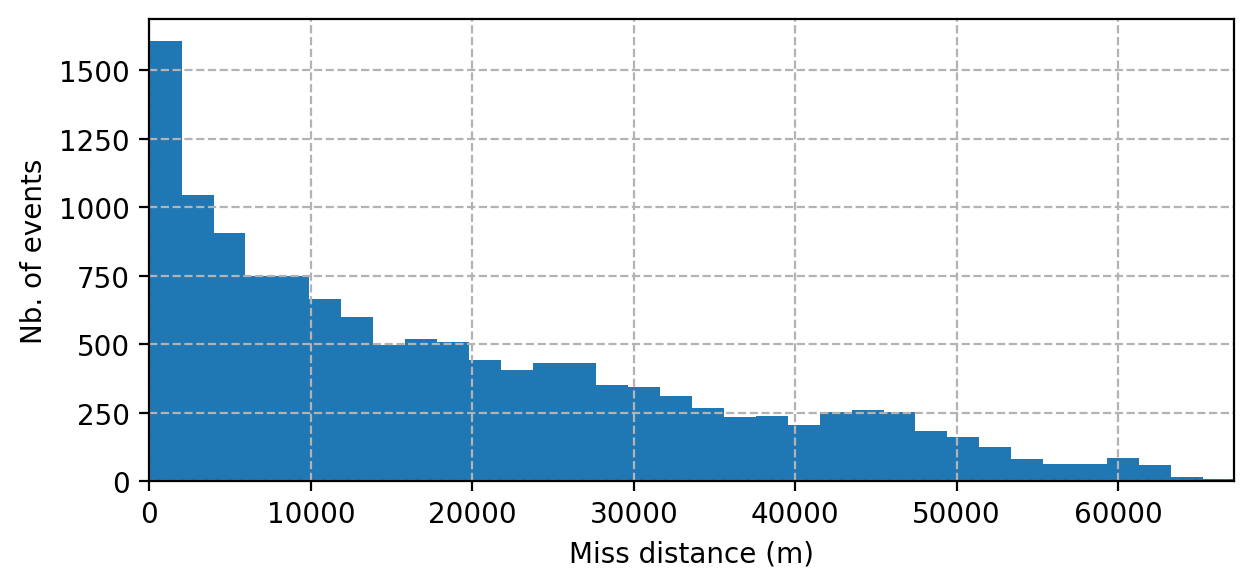

In [6]:
# Get data to plot
data = df_lastCDM['miss_distance'].to_numpy()

# Plot histogram of miss_distance
plt.figure(figsize=(7,3))
plt.hist(data, bins = nbins(data, 'fd'))
plt.xlim(0, data.max())
plt.ylabel(r'Nb. of events')
plt.xlabel(r'Miss distance (m)')
plt.grid(True, linestyle='--')
plt.show()

### 2.2. - Keplerian elements distribution analysis

In this section the following orbital elements are analysed:

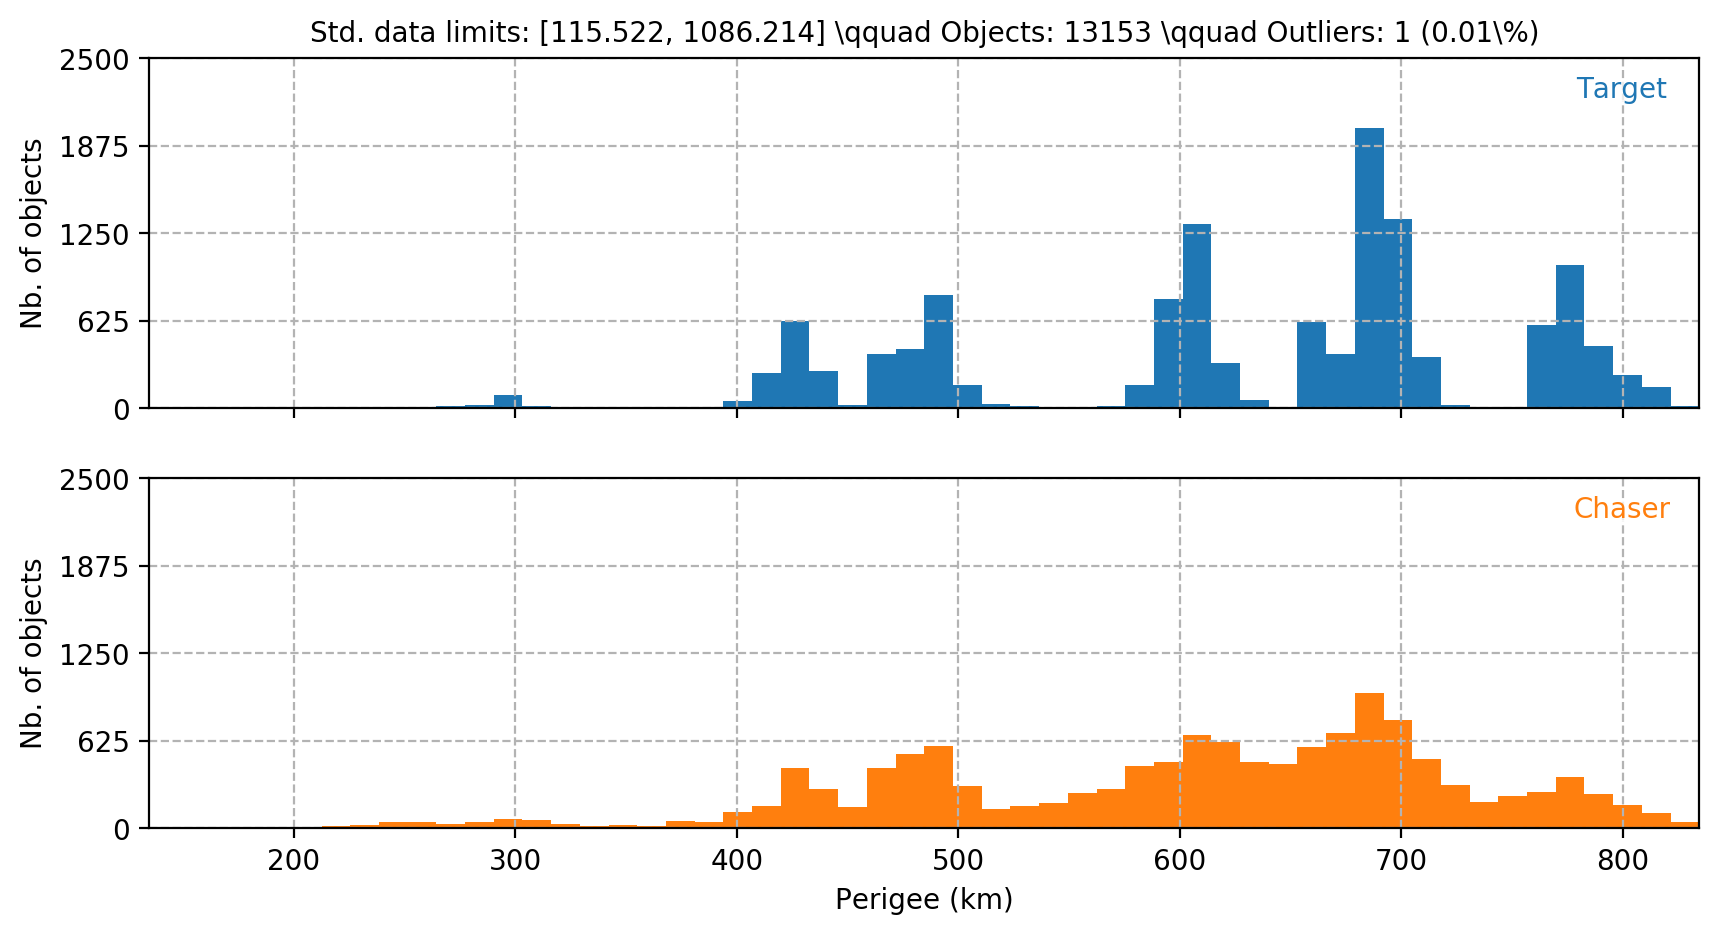

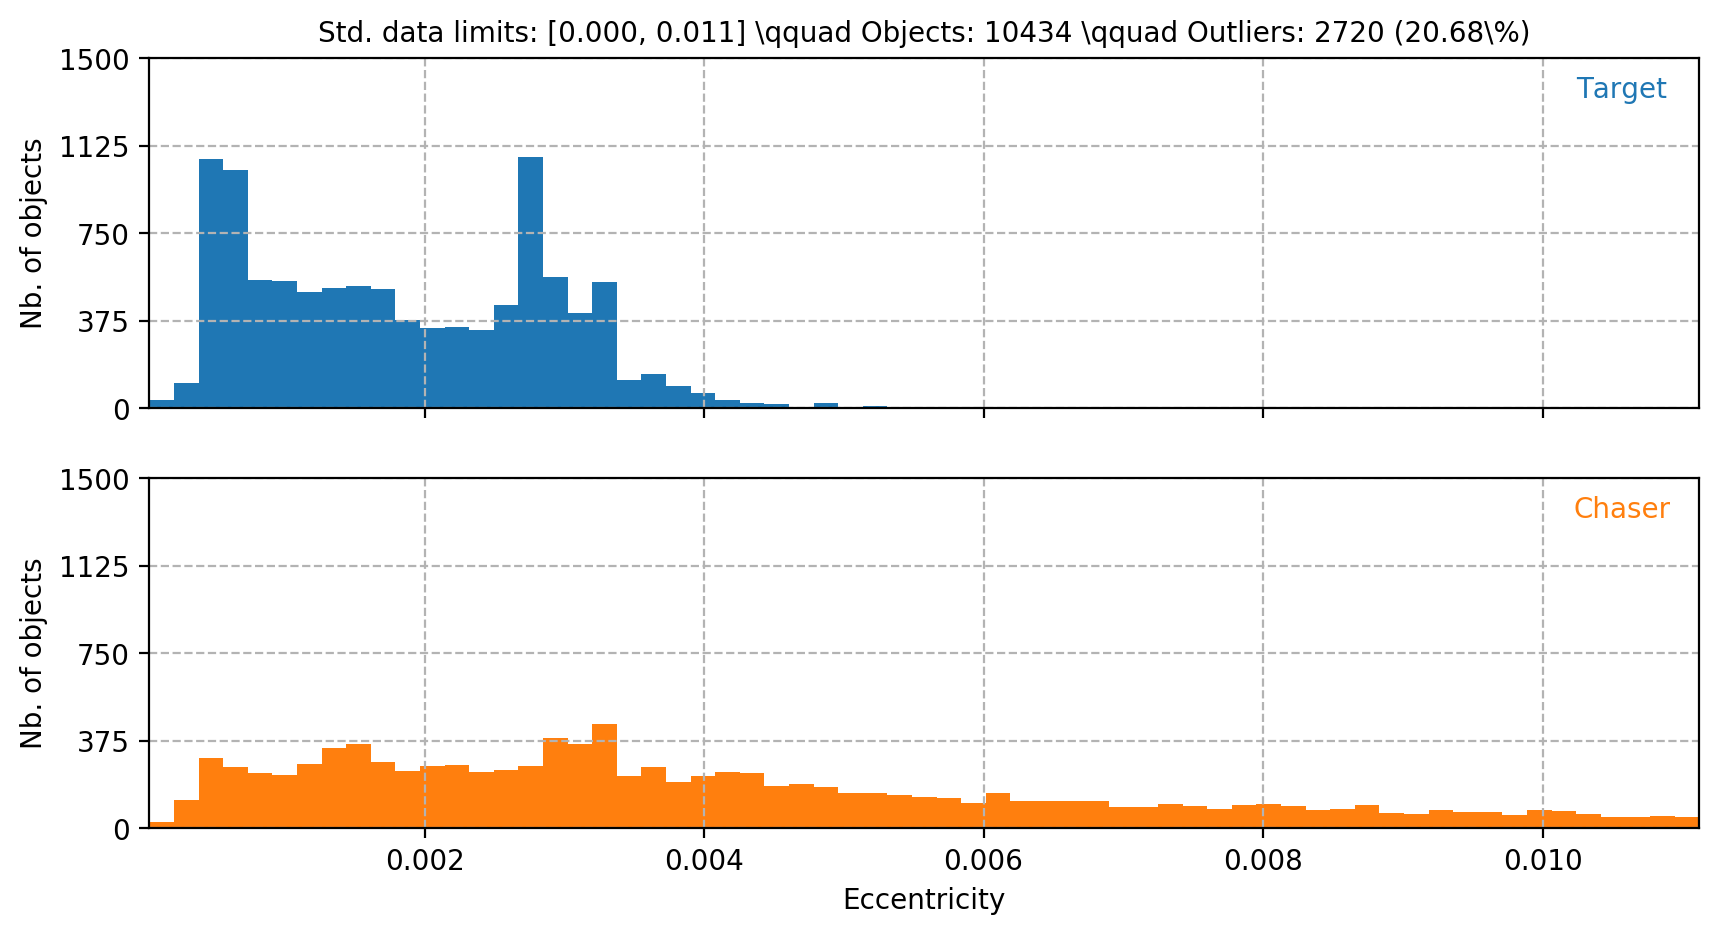

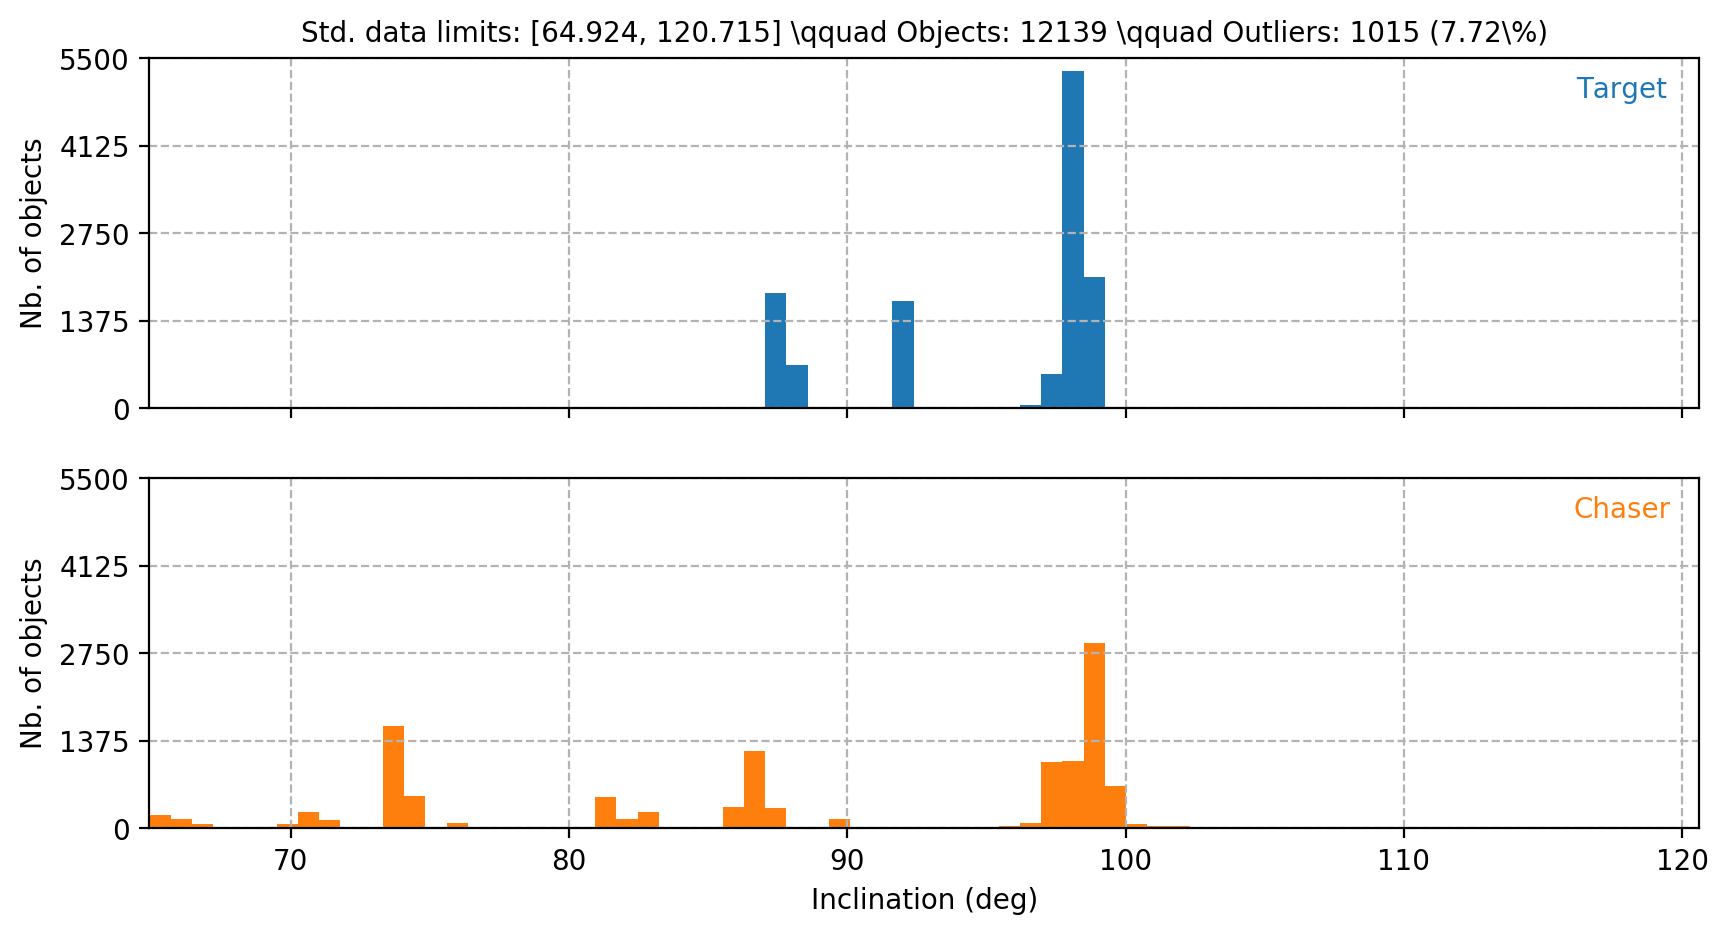

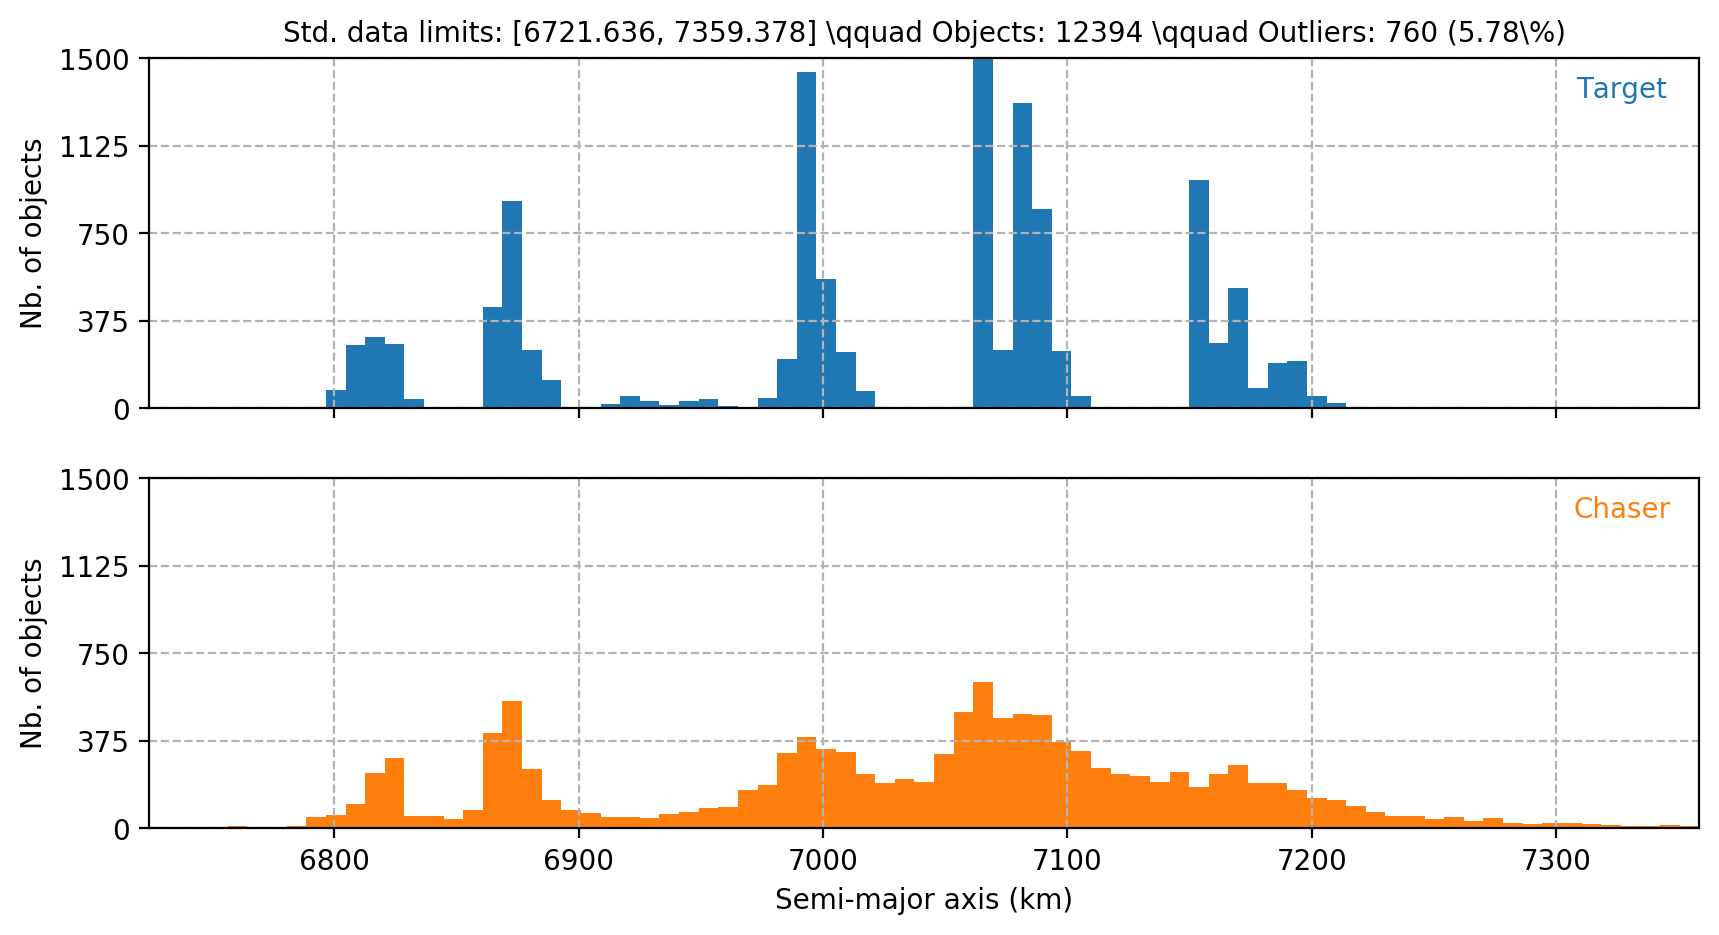

In [7]:
# Define orbital elements columns dictionary
keColumns = {'_h_per':   'Perigee (km)', 
             '_j2k_ecc': 'Eccentricity', 
             '_j2k_inc': 'Inclination (deg)', 
             '_j2k_sma': 'Semi-major axis (km)'}

# Iterate over all orbital elements
for eType, eName in keColumns.items():
    
    # Get orbital element data from both target and chaser objects to compute outliers boundaries
    objects_data = pd.concat([df_lastCDM['t' + eType],df_lastCDM['c' + eType]]).to_numpy()
    std_lims = outliers_boundaries(objects_data, 2.0)
    
    # Get subset of orbital elements of both objects from the main dataframe
    data = df_lastCDM[['t' + eType,'c' + eType]].copy()
    
    # Iterate over target and chaser subsets to filter out outliers
    for obj in data.columns:
        
        # Get the filter for the column of the measure.
        outliers_filter = (data[obj]<std_lims[0]) | (data[obj]>std_lims[1])

        # Drop values that meet the outlier condition.
        data.drop(data[outliers_filter].index, inplace=True)
        
    # Calculate number of outliers for the orbital element
    nb_outliers = len(df_lastCDM.index) - len(data)
    
    # Create figure object
    fig, axs = plt.subplots(nrows=2, figsize=(10, 5), squeeze=True, 
                            sharex=True, sharey=True)
    
    # Set plot title to indicate boundaries for standard data and outliers excluded from histogram.
    axs[0].set_title(r'Std. data limits: [{:.3f}, {:.3f}] \qquad Objects: {:d} \qquad Outliers: {:d} ({:.2f}\%)'\
                     .format(max(0,std_lims[0]), std_lims[1], len(data),  
                             nb_outliers, nb_outliers/len(df_lastCDM.index)*100), 
                     fontsize=10)
    
    # Get minimum and maximum from data
    xlim = (data.min().min(), data.max().max())
    
    # Plot charts in subplot for both objects
    colors = ['tab:blue','tab:orange']
    
    # Calculate number of bins to plot histogram 
    bins = nbins(pd.concat([data['t' + eType],data['c' + eType]]).to_numpy(), 'fd')
    
    for i, obj in enumerate(['target', 'chaser']):
        
        
        # Plot histogram for the object and keplerian element.
        axs[i].hist(data[obj[0] + eType], color=colors[i], range=xlim, 
                    bins = bins, label=r'' + obj.capitalize())
        
        # Get the limits of Y-axis to reformat plot.
        ylim = (axs[i].get_ylim()[0], ((axs[i].get_ylim()[1]//1000)+0.5)*1000)

        axs[i].grid(True, linestyle='--')
        axs[i].set_yticks(np.linspace(ylim[0],ylim[1],5))
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        axs[i].set_ylabel(r'Nb. of objects')
        
        # Plot label to identify which object the chart belongs to
        axs[i].text(0.95, 0.95, r'' + obj.capitalize(), size=10, ha='center', va='top', 
                    c=colors[i], transform=axs[i].transAxes, 
                    bbox=dict(facecolor='white', alpha=0.75, edgecolor='white', pad=-1))

    
    axs[1].set_xlabel(r'' + eName)
    
    
    plt.show()


# 3. - Probability Density Estimation for synthetic data generation

[Introduction to Probability Density Estimation](https://machinelearningmastery.com/probability-density-estimation/)

This analysis includes the two different ways to estimate the probability density associated to a given data distribution:

 - **Parametric**: the statistical distribution of the real data is described by an analytical and well-known statistical probability distribution by estimating the parameters implicit in the function.
 
 - **Non-parametric**: alternative method when the data distribution cannot be appropriately described analytically by a common probability distribution or cannot be easily made to fit the distribution (as it happens with multi-modal distributions). Among the multiple non-parametric methods available for Probability Density Estimation, the method used for estimating the probability density function of a continuous random variable in this analysis is the so-called Kernel Density Estimation (KDE).
 
The probability density function with wich all relevant continuous variables for which new data shall be generated, are fitted using both parametric and non-parametric methods and compared between each other to identify the one with the lowest Error Sum of Squares (SSE). For the parametric approach, a function is defined to find the statistical distribution that best fits the real data distribution of all existing continuous distributions available in [SciPy.org](https://docs.scipy.org/doc/scipy/reference/stats.html). In the non-parametric approach the `KernelDensity` estimator is used from [Scikit-learn.org](https://scikit-learn.org/stable/modules/density.html) to fit a function to the continuous variable.

### 3.1. - Parametric Probability Density estimation

The process to fit a parametric probability density estimation follows a series of steps for which it is convenient to develop segregated functions. For this purpose, the following functions are defined:
 - `fit_distribution`: Fits a statistical continuous distribution to the input data. It returns the distribution, its parameters adjusted, and the resulting SSE.
 - `make_pdf`: It creates an array to represent the probability density function using a given fitted distribution and its parameters.
 - `plot_dist`: Plots the probability density function and the data distribution histogram on a single chart for a visual interpretation of the probability density estimation. It supports the reader/data analyst to check appropriate fitting; some distributions may return low SSE but does not appropriately describe de distribution.


In [8]:


# Define function to fit statistical distribution to the data.
def fit_distribution(stdist, data, bins):
    
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0
    
    # Best holders
    dist = {'dist': st.norm, 'params': (0.0, 1.0), 'sse': np.inf}
    
    # Try to fit the distribution
    try:
        # Ignore warnings from data that can"t be fit
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")

            # fit dist to data
            params = stdist.fit(data)

            # Separate parts of parameters
            arg = params[:-2]
            loc = params[-2]
            scale = params[-1]

            # Calculate fitted PDF and error with fit in distribution
            pdf = stdist.pdf(x, loc=loc, scale=scale, *arg)
            sse = np.sum(np.power(y - pdf, 2.0))

            # identify if this distribution is better
            dist['dist']    = stdist
            dist['params']  = params
            dist['sse']     = sse
            
    except Exception:
        pass
    
    return dist

# Define function to generate distributions's Probability Distribution Function 
def make_pdf(dist, params, size=10000):

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get same start and end points of distribution
    start = dist.ppf(1e-4, *arg, loc=loc, scale=scale) \
        if arg else dist.ppf(1e-4, loc=loc, scale=scale)
    end = dist.ppf(1-1e-4, *arg, loc=loc, scale=scale) \
        if arg else dist.ppf(1-1e-4, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

## Define function to plot Probability Density Function with the histogram on the same chart
def plot_distribution(data, dist, bins=50):
    
    # Make Probability Density Function with distribution parameters 
    pdf = make_pdf(dist['dist'], dist['params'])
    
    # Get information of the parameters
    param_names = (dist['dist'].shapes + ", loc, scale").split(", ") \
        if dist['dist'].shapes else ["loc", "scale"]
            
    # Create string with all parameters to print into the plot's title       
    title = (dist['dist'].name).capitalize() + '\n' + \
                "\quad ".join(["{} = {:0.5f}".format(k,v) \
                for k,v in zip(param_names, dist['params'])])
    title = title + '\n(SSE = {:1.4e})'.format(dist['sse'])

    # Display plot
    plt.figure(figsize=(6,3))

    ax = pdf.plot(lw=1.5, color = "orange", label="PDF")
    data.plot(kind="hist", bins=bins, ax=ax, density=True, 
              label="Data", color="dimgrey")
    
    plt.title("{}".format(title), fontsize=12)
    plt.xlabel(data.name)
    plt.ylabel(r"Probability density")
    plt.grid(True, linestyle="dashed", alpha=0.5)
    plt.legend(loc="best", fontsize=10)
    plt.show()
    
    return

As described previously, for the parametric approach the function `find_best_distribution` is defined to find the statistical distribution that best fits the real data distribution of all existing continuous distributions available in [SciPy.org](https://docs.scipy.org/doc/scipy/reference/stats.html). To do so, the algorithm retrieves all existing continuous distributions, tries to fit it to the real data, computes the SSE and compare to the best fit found so far. It returns the best statistical distribution which corresponds to the one with the lowest SSE.

In [9]:
# Define function to find best fitted distribution (according to lowest SSE)
def find_best_distribution(data, bins=200, st_excluded=[]):
    
    # Get Continuous distributions table from SciPy website.
    url = 'https://docs.scipy.org/doc/scipy/reference/stats.html'
    dist_table = pd.read_html(requests.get(url).content)[1]
    
    # Evaluate list of objects in str format to convert it into a Python list
    stdist_list = []
    
    # Iterate through all the continous distributions on the website and evaluate it
    # to discard those that are not compatible with the library version installed.

    for idist in dist_table[0]:
        try:
            stdist_list.append(eval('st.' + idist))
            print(idist)
        except Exception:
            pass
    
    # Initialize best distribution
    best_dist = {'dist': st.norm, 'params': (0.0, 1.0), 'sse': np.inf}
    
    dists_checked = []

    # Estimate distribution parameters from data
    for i, stdist in enumerate(stdist_list):
        
        # If statistical distribution is in the exclusion list skip fitting process.
        if stdist.name in st_excluded: continue
        
        # Fit stdist to real data
        dist = fit_distribution(stdist, data, bins)
        clear_output(wait=True)
        print('Progress %5.1f%% (%3d/%3d)  Best: %10s (SSE: %1.3e)  Distribution: %10s (SSE: %1.3e) \t' %
              ((i+1)/len(stdist_list)*100, i, len(stdist_list)-1, best_dist['dist'].name, best_dist['sse']
               , dist['dist'].name, dist['sse']), end='\r')
        
        # If it improves the current best distribution, reassign best distribution
        if best_dist['sse'] > dist['sse'] > 0: best_dist = dist
        
        dists_checked.append(stdist.name)
        
    # Get information of the parameters
    param_names = (dist['dist'].shapes + ", loc, scale").split(", ") \
                    if dist['dist'].shapes else ["loc", "scale"]
        
    
    params = ""
    for p, v in zip(param_names, best_dist['params']): 
        params = params + "\n - "+ p + " = " + str(v)
    
    # Clear output to print final results
    clear_output(wait=True)
    
    # Print final results
    print("\nBest dist.: %s (Bins %d / SSE: %1.3e)\nParameters:%s" % \
          (best_dist['dist'].name, bins, best_dist['sse'], params))
    
    return best_dist

In [11]:
# import csv

str_dists = "alpha anglit arcsine argus beta betaprime bradford burr burr12 cauchy chi chi2 cosine crystalball dgamma dweibull erlang expon exponnorm exponweib exponpow f fatiguelife fisk foldcauchy foldnorm genlogistic gennorm genpareto genexpon genextreme gausshyper gamma gengamma genhalflogistic genhyperbolic geninvgauss gibrat gompertz gumbel_r gumbel_l halfcauchy halflogistic halfnorm halfgennorm hypsecant invgamma invgauss invweibull johnsonsb johnsonsu kappa4 kappa3 ksone kstwo kstwobign laplace laplace_asymmetric levy levy_l levy_stable logistic loggamma loglaplace lognorm loguniform lomax maxwell mielke moyal nakagami ncx2 ncf nct norm norminvgauss pareto pearson3 powerlaw powerlognorm powernorm rdist rayleigh rice recipinvgauss semicircular skewcauchy skewnorm studentized_range t trapezoid triang truncexpon truncnorm truncweibull_min tukeylambda uniform vonmises vonmises_line wald weibull_min weibull_max wrapcauchy"

print(str_dists.split(' '))

try:
    # Get Continuous distributions table from SciPy website.
    url = 'https://docs.scipy.org/doc/scipy/reference/stats.html'
    dist_table = pd.read_html(requests.get(url).content)[1]
    
    # Iterate through all the continous distributions on the website and evaluate it
    # to discard those that are not compatible with the library version installed.
    df_dists = pd.DataFrame(data=dist_table[0].to_list(), columns=['scipy_distributions'])
    df_dists.to_csv(os.path.join(cwd,'temp_scipy-distributions.csv'), sep=',')
        
except Exception:
    print("Could not read SciPy.org website. Importing data from local file...")
    # Import training dataset
    df_dists = pd.read_csv(os.path.join(cwd,'data','notebook-outputs','temp_scipy-distributions.csv'), 
                            sep=',', header=0, index_col=None, skipinitialspace=False)
    pass
    

['alpha', 'anglit', 'arcsine', 'argus', 'beta', 'betaprime', 'bradford', 'burr', 'burr12', 'cauchy', 'chi', 'chi2', 'cosine', 'crystalball', 'dgamma', 'dweibull', 'erlang', 'expon', 'exponnorm', 'exponweib', 'exponpow', 'f', 'fatiguelife', 'fisk', 'foldcauchy', 'foldnorm', 'genlogistic', 'gennorm', 'genpareto', 'genexpon', 'genextreme', 'gausshyper', 'gamma', 'gengamma', 'genhalflogistic', 'genhyperbolic', 'geninvgauss', 'gibrat', 'gompertz', 'gumbel_r', 'gumbel_l', 'halfcauchy', 'halflogistic', 'halfnorm', 'halfgennorm', 'hypsecant', 'invgamma', 'invgauss', 'invweibull', 'johnsonsb', 'johnsonsu', 'kappa4', 'kappa3', 'ksone', 'kstwo', 'kstwobign', 'laplace', 'laplace_asymmetric', 'levy', 'levy_l', 'levy_stable', 'logistic', 'loggamma', 'loglaplace', 'lognorm', 'loguniform', 'lomax', 'maxwell', 'mielke', 'moyal', 'nakagami', 'ncx2', 'ncf', 'nct', 'norm', 'norminvgauss', 'pareto', 'pearson3', 'powerlaw', 'powerlognorm', 'powernorm', 'rdist', 'rayleigh', 'rice', 'recipinvgauss', 'semicirc

FileNotFoundError: [Errno 2] File /private/var/mobile/Containers/Shared/AppGroup/DB327911-0EF0-4E9B-BDCE-B3DCAC932704/File Provider Storage/Repositories/SCA-Tool/data/notebook-outputs/temp_scipy-distributions.csv does not exist: '/private/var/mobile/Containers/Shared/AppGroup/DB327911-0EF0-4E9B-BDCE-B3DCAC932704/File Provider Storage/Repositories/SCA-Tool/data/notebook-outputs/temp_scipy-distributions.csv'

In [ ]:
fitting_data = []
for row in some_function_that_yields_data():
    fitting_data.append([])

df = pd.DataFrame(data=fitting_data, columns=['distribution', 'sse', 'parameters'])
df.to_csv('temp-distribution_fitting_results.csv', sep=',')

Computing `find_best_distribution` function over all relevant continuous variables the results are the following:


Best dist.: kappa4 (Bins 30 / SSE: 1.451e-10)
Parameters:
 - c = 1.3494587292521154
 - loc = 0.5323246855242685
 - scale = -11604.97372459666
0              alpha
1             anglit
2            arcsine
3              argus
4               beta
           ...      
98     vonmises_line
99              wald
100      weibull_min
101      weibull_max
102       wrapcauchy
Name: 0, Length: 103, dtype: object


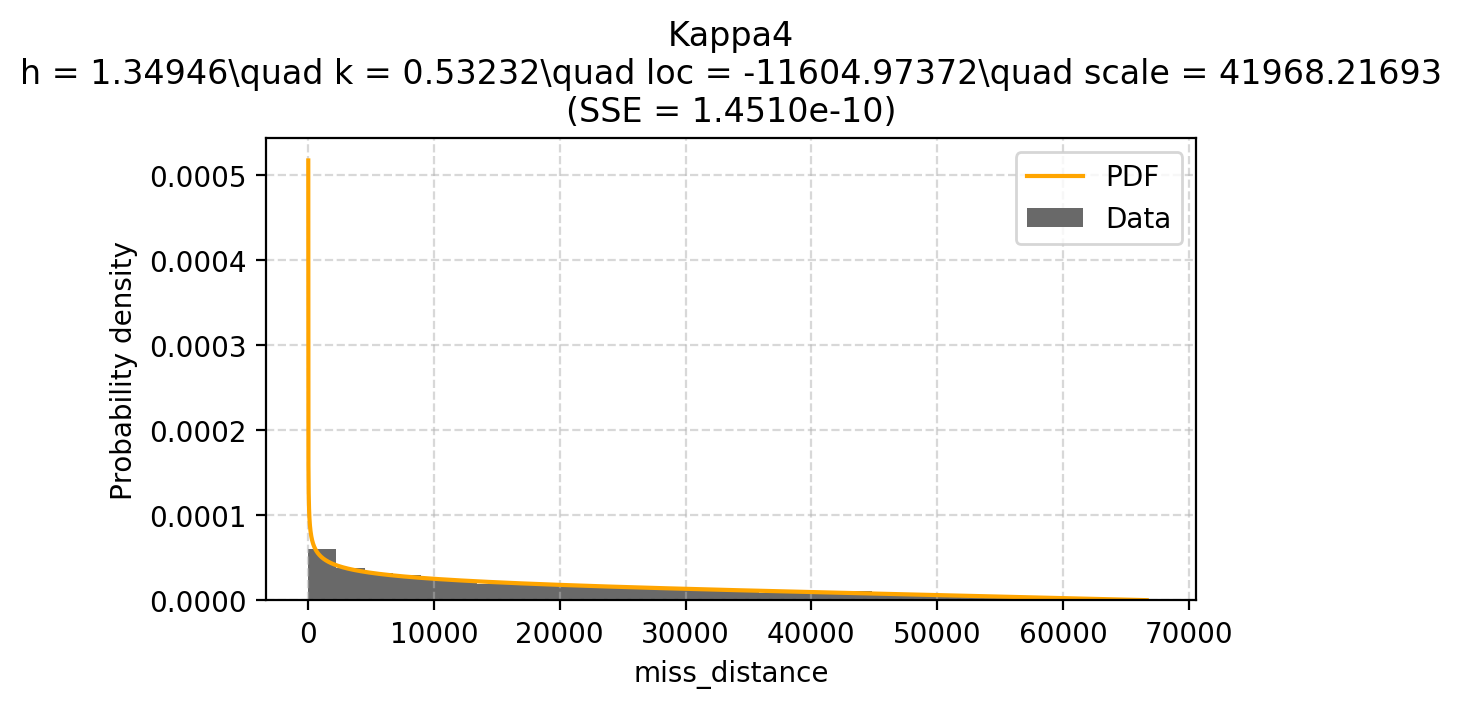

In [12]:
# Set column name to study and remove outliers.
variable = 'miss_distance'
data = df_lastCDM[variable]

# Define list of continuous distributions to exclude from the fitting process
stdist_excluded = ['studentized_range', 'levy_l_gen', 'levy_stable']

# Find distribution that best fits the data
dist = fit_distribution(st.beta, data, 30)
dist = find_best_distribution(data, 30, stdist_excluded)
    
# Print plot including histogram and distribution fitted
plot_distribution(data, dist, 30)

The best statistical distribution that describe `miss_distance` data distribution seems to approximate very well but it tends to infinity when the variable approaches 0. To prevent this problem from happening, a different approach could be taken into account involving a pseudo-symmetric data distribution. This is performed by adding the same data distribution with negative values for the `miss_distance`:

In [ ]:
# Set column name to study and remove outliers.
variable = 'miss_distance'
data_mirroring = pd.concat([df_lastCDM[variable], df_lastCDM[variable].apply(lambda x: x*-1)])

# Define list of continuous distributions to exclude from the fitting process
stdist_excluded = ['studentized_range', 'levy_l_gen', 'levy_stable']

# Calculate number of bins
bins = nbins(data_mirroring, 'sturge')

# Find distribution that best fits the data
# dist = find_best_distribution(data_mirroring, bins, stdist_excluded)
dist = fit_distribution(st.laplace_asymmetric, data_mirroring, bins)
    
# Print plot including histogram and distribution fitted
plot_distribution(data_mirroring, dist, bins)

### 3.2. - Non-Parametric Probability Density Estimation using KDE

In [ ]:
# Initialize array with all available kernels in KernelDensity
kernels = ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]

# Set column name to study and remove outliers.
variable = 'miss_distance'
data = pd.concat([df_lastCDM[variable], df_lastCDM[variable].apply(lambda x: x*-1)])

# Get both object's data
data = data.to_numpy().reshape(-1,1)

# Get number of bins for appropriate histogram representation
bins = nbins(data, 'sturge')

# Get probability density from real data
dens_data, bin_edges = np.histogram(data, bins=bins, density=True)

X = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0

# Create figure to plot probability densities and histogram
fig, ax_hist = plt.subplots(figsize=(6,3))

# Create a secondary axis for the histogram.
ax_dens = ax_hist.twinx()
    
ax_hist.hist(data, bins=bins, alpha=0.5, color='gray')
ax_dens.plot(X, dens_data, label=r'Data', color='blue')

ax_dens.set_xlabel(r'Miss distance (km)')
ax_dens.set_ylabel(r'Probability Density', color='blue')
ax_hist.set_ylabel(r'Nb. of events', color='gray')
    
ax_dens.set_ylim(0,dens_data.max())
plt.grid(True, linestyle='--')
plt.show()

In [ ]:
# Initialize array with different values for the bandwidth
bandwidths = np.arange(0.1,5.1,0.05)

# Initialize array to store SSE
sse = np.zeros_like(bandwidths)

# Create plot object to compare all kernels as a function of the bandwidth
plt.figure(figsize=(8,5))

# Iterate through all kernels
for kernel in kernels:
    
    # Iterate through bandwidths
    for i, bandwidth in enumerate(bandwidths):
        
        # Fit the Kernel Density Estimator
        kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(data)
        
        # Compute the log-likelihood of each sample under the model.
        dens_estimated = np.exp(kde.score_samples(X.reshape(-1,1)))
    
        # Compute Sum of Squared Errors (SSE) for the density estimation
        sse[i] = np.sum((dens_estimated - dens_data)**2)
    
    # print(np.vstack((bandwidths, sse)).T)
    
    plt.plot(bandwidths, sse, label=r'' + kernel)
    

plt.title(r'Comparison between Kernels given a bandwidth')

plt.ylabel(r'Sum of Squared Errors (SSE)')
plt.xlabel(r'Bandwidth')

# Define X-axis ticks and limits
plt.xticks(np.arange(0.0,bandwidths.max(),0.5))
plt.xlim(0.0, bandwidths.max())

# Define Y-axis ticks and limits
plt.yticks(np.linspace(0.0, sse.max(),10))
plt.ylim(0.0, sse.max())

plt.grid(True, linestyle='--')
plt.legend(loc='best')
plt.show()
    


In [ ]:
# Set column name to study and remove outliers.
variable = 'miss_distance'
# data = pd.concat([df_lastCDM[variable], df_lastCDM[variable].apply(lambda x: x*-1)]).to_numpy().reshape(-1,1)
data = df_lastCDM[variable].to_numpy().reshape(-1,1)

# Get number of bins for appropriate histogram representation
bins = nbins(data, 'sturge')

# Get probability density from real data
dens_data, bin_edges = np.histogram(data, bins=30, density=True)

# Determine center of every histogram bin
X = (bin_edges + np.roll(bin_edges, -1))[:-1] / 2.0

# Define the kernel to be used:
kernel = 'exponential'

# Create figure to plot probability densities and histogram
fig, ax_hist = plt.subplots(figsize=(6,3))

# Create a secondary axis for the histogram.
ax_dens = ax_hist.twinx()

# Plot histogram and probability density from the real data.
ax_hist.hist(data, bins=bins, alpha=0.5, color='gray')
#ax_dens.plot(X, dens_data, label=r'Data', linestyle='--')

# Check different bandwidths for the kernel density estimation
for bandwidth in np.linspace(750,10000,1):
    
    # Compute kernel density model
    kde = KernelDensity(kernel=kernel, bandwidth=bandwidth).fit(data)

    # Compute the log-likelihood of each sample under the model.
    dens_estimated = np.exp(kde.score_samples(X.reshape(-1,1)))

    # Plot estimated density using the kernel
    ax_dens.plot(X, dens_estimated, label=r'bw={:.1f}'.format(bandwidth), linewidth=3, alpha=0.5)


ax_dens.set_xlabel(r'Miss distance (km)')
ax_dens.set_ylabel(r'Probability Density')
ax_hist.set_ylabel(r'Nb. of events')

ax_dens.set_ylim(0,dens_data.max())
plt.grid(True, linestyle='--')
plt.legend(loc='best')
plt.show()

In [ ]:
data = df_lastCDM['miss_distance'].to_numpy().reshape(-1,1)


grid = GridSearchCV(KernelDensity(kernel='exponential'),
                    {'bandwidth': np.linspace(120, 130, 20)},
                    cv=5) # 20-fold cross-validation
grid.fit(data)
print(grid.best_params_)

In [ ]:
# Get both object's data
data = df_lastCDM['miss_distance']

# Create kernel to estimate probability over the population
kde = st.gaussian_kde(data, bw_method='scott')
    
# Get minimum and maximum from data
x = np.linspace(data.min(), data.max(), 100)

# Plot the probability density distribution estimated function
plt.figure(figsize=(6,3), layout='tight')
plt.plot(x, kde(x))
plt.title(r'Probability density estimate')
plt.xlabel(r'Miss distance (km)')
plt.grid(True, linestyle='--')
plt.show()

In [ ]:
# Run through both type of objects
for eType, eName in keColumns.items():
    
    # Get both object's data
    data = df_lastCDM[['t' + eType,'c' + eType]]
    
    # Get minimum and maximum from data
    xlim = (data.min().min(), data.max().max())
    
    x = np.linspace(xlim[0], xlim[1], 100)
    
    plt.figure(figsize=(6,3), layout='tight')
    
    for oType, oPreffix in objects.items():
    
        # Create kernel to estimate probability over the population
        kde = st.gaussian_kde(data[oPreffix + eType], bw_method='scott')
        
        plt.plot(x, kde(x), label=r'' + oType.capitalize())
        
    # print('KDE Bandwith method = %.4f' % kde.n**(-1./(kde.d+4)))
    plt.title(r'Probability density estimate')
    plt.xlabel(eName)
    plt.grid(True, linestyle='--')
    plt.legend(loc='best')
    plt.show()